## National Center for Atmospheric Research
## 2017 Climate Informatics Hackathon: California Seasonal Rainfall Prediction Starting Kit
Author: David John Gagne II

Special thanks to Balazs Kegl and Andy Rhines for assistance with setting up the contest and Jeanine Jones for inspiring the contest problem with her talk at the Big Data and Earth Science Challenges Workshop

## Introduction
<img src="Oroville_dam_spillway_2017-02-11.jpg" width="600px">
_Water flowing over the damaged Oroville Dam Spillway. Image source:_ [William Croyle, California Department of Water Resources](https://commons.wikimedia.org/wiki/File:Oroville_dam_spillway_2017-02-11.jpg)

The state of California receives most of its annual rainfall during the winter months when storms fueled by moisture from the tropical Pacific impact the state. This past winter was the wettest on record for northern California, resulting in massive floods and over 1 billion dollars in damage. Storm runoff into Lake Oroville led to extensive releases of water along the Oroville Dam spillway. The main spillway was damaged during the releases but continued to be used due to the high volume of water. The emergency spillway then had to be used, which prompted fears of containment failure and led to large evacuations downstream of the dam. The cost to repair the spillway is estimated at 400 million dollars.

Some of the flooding problems associated with dams in northern California could be managed better with more accurate seasonal and subseasonal forecasts of rainfall. If water managers had a skilled forecast of expected rainfall, then they could change the distribution of water in northern California to be more resilient to large rainfall events. The mitigation process can take weeks to complete, so seasonal forecast leadtimes are needed for effective mitigation. Current operational seasonal precipitation guidance from the NOAA Climate Prediction Center has no skill above climatology for northern California and is not presented in a way that is useful for water managers at the California Department of Water Resources. Current seasonal precipitation forecasting relies primarilly on teleconnection indices, such as ENSO. However, these indices individually are poorly correlated with northern California winter rainfall. For example, the "Godzilla" El Nino of 2015-2016 was expected to bring very heavy rain to California but no extreme rains appeared in the winter of 2015-16. Last years heavy rains happened when ENSO was closer to a neutral state. Other teleconnections should also have some correlation with California rainfall, but finding the most important connections and how they interact is not a task that can be easily done manually.

The goal for the 2017 Climate Informatics Hackathon is to use the November-averaged atmospheric fields to predict the probability of at least 750 mm of rain in northern California between December and February. The observational record for northern California rainfall only goes back to the early 1920s, which would provide a very limited sample size for machine learning or statistical models. Therefore, we are going to use climate model output from simulations run over the last 1000 years. By using climate model output, we hope to sample better the range of possible combinations of weather patterns and rainfall and fit more complex ML and statistical models.

## NCAR Last Millennium Ensemble
The [NCAR Last Millennium Ensemble](http://www.cesm.ucar.edu/projects/community-projects/LME/) is a set of CESM climate model runs starting in 850 AD and run through 2005. The 850 to 1850 period covers preindustrial conditions and 1850-2005 covers the industrial era. This hackathon uses the 12 full forcing ensemble members, which use the same forcings but had their initial air temperature fields perturbed by a small random roundoff of $10^{-14}$C. The ensemble members thus capture the internal variability within the model's climate system. More information about the Last Millennium Ensemble can be found in its [BAMS paper](http://www.cesm.ucar.edu/projects/community-projects/LME/publications/Otto-Bliesner_BAMS-LME_2016-2.pdf).

## The Data
* TS: temperature at the surface (K)
* PSL: mean sea level pressure (Pa) (not Pumpkin Spice Lattes!)
* TMQ: precipitable water (mm)
* U_500: west-east component of the wind at the 500 mb pressure level (m/s)
* V_500: south-north component of the wind at the 500 mb pressure level (m/s)

## Requirements
The Anaconda or Miniconda Python distributions are recommended for downloading the dependencies for this hackathon. Python 3.5 or greater is highly recommended. The following libraries are required. 
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* cartopy

Once Anaconda or Miniconda is installed on your local machine, execute the following command to create a conda environment with all of the required libraries. 
```bash
cd ~/ramp_kits/california_rainfall/
conda env create -f environment.yml
source activate ramp_ci_2017
```
Download the data to your local machine by running the script download_data.py.
```bash
python download_data.py
```
The data should appear in the data directory of the starting kit.

In [3]:
%matplotlib inline
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import cartopy.crs as ccrs
from ipywidgets import interact, SelectionSlider
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

## Loading the Data
Each variable is stored in a separate netCDF file. The data loading function is below. If your laptop does not have a large amount of RAM (< 4 GB), we highly recommend loading a smaller subset of variables. 

In [4]:
# Edit this list of variables to load in a smaller subset.
data_vars = ["TS", "PSL", "TMQ", "U_500", "V_500"]

def read_data(path, f_prefix, data_vars):
    X_coll = []
    for data_var in data_vars:
        nc_file = join(path, "data", f_prefix + "_{0}.nc".format(data_var))
        print(nc_file)
        ds = xr.open_dataset(nc_file, decode_times=False)
        ds.load()
        X_coll.append(ds[data_var].stack(enstime=("ens", "time")).transpose("enstime", "lat", "lon"))
        ds.close()
    X_ds = xr.merge(X_coll)
    y = pd.read_csv(join(path, "data", f_prefix + "_precip_90.csv"), index_col="Year")
    y_array = np.concatenate([y[c] for c in y.columns])
    return X_ds, y_array

In [5]:
train_X, train_y = read_data("./", "train", data_vars)

./data/train_TS.nc
./data/train_PSL.nc
./data/train_TMQ.nc
./data/train_U_500.nc
./data/train_V_500.nc


In [6]:
train_X["TS"].sel(ens=0, time=334.0).shape

(96, 144)

## Viewing the Data
The training data fields are viewable with this interactive widget. Check out the amount of variability among ensemble members and how different fields are linked with each other.

In [7]:
years = np.arange(850, 2005)
def plot_grid(ens, year, var):
    ti = np.where(year == years)[0][0]
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    min_val = train_X[var].min()
    max_val = train_X[var].max()
    cont = ax.contourf(train_X["lon"] - 180, train_X["lat"], 
                       train_X[var].sel(ens=ens, time=train_X["time"].values[ti]),
                       np.linspace(min_val, max_val, 20))
    ax.set_title(var + " " + "Year: {0:d} Member {1}".format(year, ens))
    plt.colorbar(cont)
interact(plot_grid, ens=[0, 1, 2, 3], year=SelectionSlider(options=years.tolist()), 
         var=data_vars)

A Jupyter Widget

<function __main__.plot_grid>

## Spatial Standardized Anomalies
Seasonal signals in spatial data may be hidden by local variability. The polar regions have larger amounts of temperature variability than the tropics, for example. Machine learning and statistical models may focus on local variability instead of spatial variability if the local variability is not controlled for. One way to do this is to normalize the data based on the temporal mean and standard deviation at each grid point. The code for this is shown below.

In [9]:
train_X_anomalies = xr.merge([(train_X[var] - train_X[var].mean(axis=0)) / (train_X[var].std(axis=0)) for var in data_vars])

Wave patterns and dipoles across the globe are now far more obvious in the standardized anomaly data than they were in the original data.

In [14]:
def plot_anomaly(ens, year, var):
    ti = np.where(year == years)[0][0]
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    min_val = -5
    max_val = 5
    cont = ax.contourf(train_X_anomalies["lon"] - 180, train_X_anomalies["lat"], 
                       train_X_anomalies[var].sel(ens=ens, time=train_X_anomalies["time"].values[ti]),
                       np.linspace(min_val, max_val, 11), cmap="RdBu_r")
    ax.set_title(var + " " + "Year: {0:d} Member {1}".format(year, ens))
    plt.colorbar(cont)
interact(plot_anomaly, ens=[0, 1, 2, 3], year=SelectionSlider(options=years.tolist()), 
         var=data_vars)

A Jupyter Widget

<function __main__.plot_anomaly>

## The Target: Northern California December-February Rainfall
Below are a few plots showing the temporal trends of northern California winter rainfall in the different LME Ensemble training members. Each member has a similar distribution of precipitation, but periods of drought and heavy rain vary differently in each model member. The temporal autocorrelation is very low from year to year.

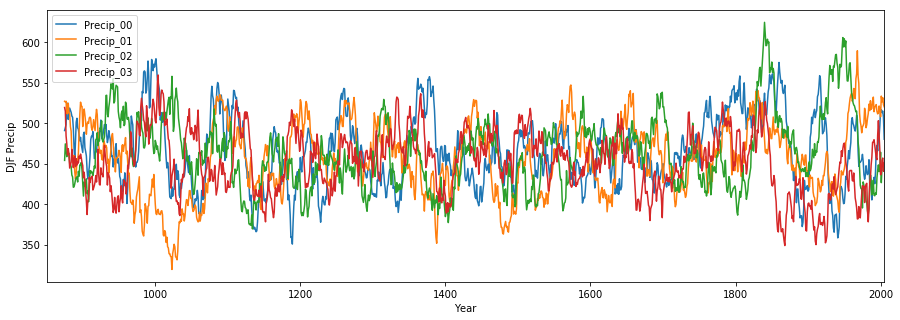

In [126]:
rain_data = pd.read_csv("data/train_precip.csv", index_col="Year")
rain_data.rolling(25).mean().plot(figsize=(15, 5))
plt.ylabel("DJF Precip")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122d76d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122ec3630>]], dtype=object)

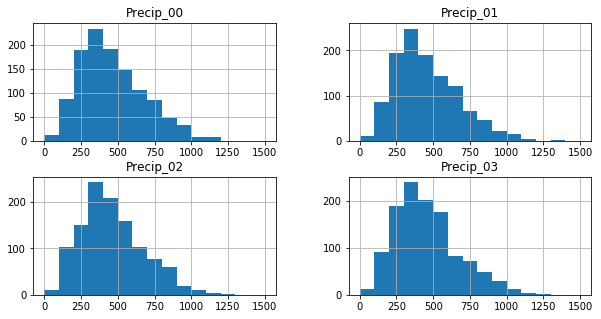

In [129]:
rain_data.hist(bins=np.arange(0, 1600, 100), figsize=(10, 5))

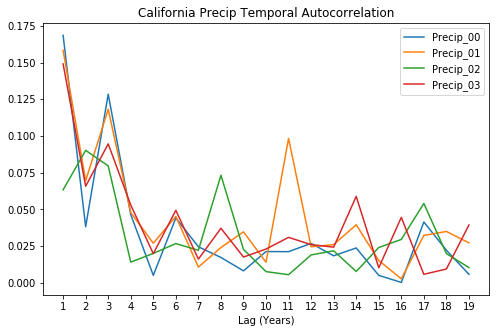

In [124]:
lags = np.arange(1, 20)
autocorr = np.zeros((rain_data.columns.size, lags.size))
plt.figure(figsize=(8, 5))
for c, col in enumerate(rain_data.columns):
    autocorr[c] = np.array([rain_data[col].autocorr(l) for l in range(1, 20)])
    plt.plot(lags, np.abs(autocorr[c]), label=col)
plt.xticks(lags)
plt.title("California Precip Temporal Autocorrelation")
plt.xlabel("Lag (Years)")
plt.legend(loc=0)

## Cross-Validation
For this contest, the cross-validation will take advantage of the relative independence of the different ensemble members. The cross-validation object trains on data from the 3 training ensemble members and tests on the fourth. A separate public testing dataset consists of 4 other ensemble members.

## The Pipeline
The machine learning pipeline for this constest consists of two components: the feature extractor and the classifier. The feature extractor transforms the spatial fields into a flat table that can be processed by scikit-learn-style machine learning and statistical models. The classifier predicts the probability of 750 mm or greater DJF rainfall. 

The starting kit feature extractor spatially normalizes the data and the performs Prinicpal Component Analysis on each variable, keeping the top 20 components. 

In [17]:
class FeatureExtractor():
    def __init__(self):
        self.means = {}
        self.sds = {}
        # Set which model variables you want to use
        self.variables = ["TS", "PSL", "TMQ"]
        self.pca = {}
        self.num_comps = 20

    def fit(self, X_ds, y): 
        # Store the mean and standard deviation for each variable
        for var in self.variables:
            if var not in self.means.keys():
                self.means[var] = X_ds[var].mean(axis=0).values
                self.sds[var] = X_ds[var].std(axis=0).values
                self.sds[var][self.sds[var] == 0] = 1 
            # Normalize the data
            var_norm = (X_ds[var] - self.means[var]) / self.sds[var]
            # Combine the latitude and longitude dimensions into a flat array
            var_flat = var_norm.stack(latlon=("lat", "lon")).values
            var_flat[np.isnan(var_flat)] = 0 
            # Create and fit the PCA
            self.pca[var] = PCA(n_components=self.num_comps)
            self.pca[var].fit(var_flat)


    def transform(self, X_ds):
        X = np.zeros((np.prod(X_ds[self.variables[0]].shape[:1]), 
                      self.num_comps * len(self.variables)), dtype=np.float32)
        c = 0 
        for var in self.variables:
            # Normalize each variable
            var_norm = (X_ds[var] - self.means[var]) / self.sds[var]
            var_flat = var_norm.stack(latlon=("lat", "lon")).values
            var_flat[np.isnan(var_flat)] = 0 
            # Transform the data into princpal components and add to flat 2D array
            X[:, c:c+self.num_comps] = self.pca[var].transform(var_flat)
            c += self.num_comps
        return X

The classifier applies a logistic regression with L1 (LASSO) regularization to the principal component data. L1 regularization results in sparse coeffients, which means that most coefficients will be set to 0. It is a way to perform implicit feature selection with a linear model without having to evaluate a large combination of input variables as in stepwise forward selection. The C parameter controls the strength of the regularization. A smaller value results in fewer non-zero coefficients while a large value leads to more non-zero coefficients. 

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = LogisticRegression(C=0.01, penalty="l1")

    def fit(self, X, y): 
        self.clf.fit(X, y)

    def predict_proba(self, X): 
        return self.clf.predict_proba(X)

In [82]:
fe = FeatureExtractor()
fe.fit(train_X, train_y)
X = fe.transform(train_X)
cls = Classifier()
cls.fit(X, train_y)

## Model Interpretation
In addition to predictive accuracy and reliability, statistical and machine learning models should also have some amount of interpretability. Linear regresssion models can be interpreted based on the magnitude of their coefficents. The plot below shows the principal component loadings associated with the top coefficients.

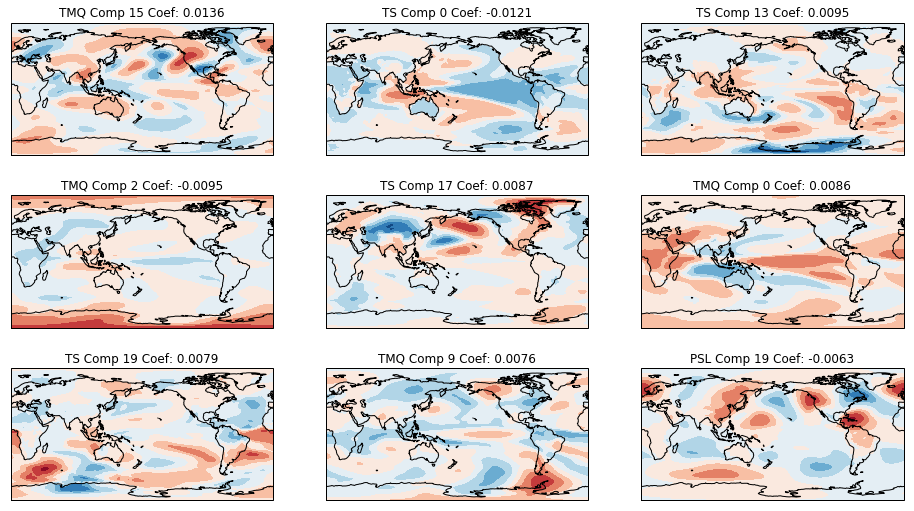

In [83]:
coefs = cls.clf.coef_[0]
coef_rankings = np.argsort(np.abs(coefs))[::-1]
fig, axes = plt.subplots(3, 3, figsize=(16, 9), 
                         subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
axef = axes.ravel()
for c, coef_rank in enumerate(coef_rankings[:9]):
    c_var = data_vars[int(np.floor(coef_rank / fe.num_comps))]
    c_comp = coef_rank % fe.num_comps
    comp_vals = fe.pca[c_var].components_[c_comp]
    axef[c].coastlines()
    axef[c].contourf(train_X["lon"] - 180, 
                     train_X["lat"], 
                     fe.pca[c_var].components_[c_comp].reshape(train_X[c_var].shape[1:]),
                     np.linspace(-0.04, 0.04, 11), cmap="RdBu_r")
    axef[c].set_title("{0} Comp {1:d} Coef: {2:0.4f}".format(c_var, c_comp, coefs[coef_rank]))

## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `ts_feature_extractor.py` and  `classifier.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train_*.nc` and `test_*.nc` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [15]:
!source activate ramp_ci_2017; ramp_test_submission

Testing California Winter Extreme Rainfall Prediction
Reading train and test files from ./data ...
./data/train_TS.nc
./data/train_PSL.nc
./data/train_TMQ.nc
./data/train_U_500.nc
./data/train_V_500.nc
./data/test_TS.nc
./data/test_PSL.nc
./data/test_TMQ.nc
./data/test_U_500.nc
./data/test_V_500.nc
./data/train_TS.nc
./data/train_PSL.nc
./data/train_TMQ.nc
./data/train_U_500.nc
./data/train_V_500.nc
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	train BSS = 0.158
	valid BSS = 0.15
	test BSS = 0.112
	train BS = 0.08
	valid BS = 0.093
	test BS = 0.077
	train BS Rel = 0.026
	valid BS Rel = 0.032
	test BS Rel = 0.02
	train BS Res = 0.167
	valid BS Res = 0.161
	test BS Res = 0.138
	train AUC = 0.813
	valid AUC = 0.808
	test AUC = 0.783
CV fold 1
	train BSS = 0.168
	valid BSS = 0.124
	test BSS = 0.103
	train BS = 0.083
	valid BS = 0.082
	test BS = 0.078
	train BS Rel = 0.029
	valid BS Rel = 0.023
	test BS Rel = 0.02
	train BS Res = 0.174
	valid BS Res = 0.142
	test BS Res 

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [california_rainfall](https://www.ramp.studio/events/california_rainfall) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/california_rainfall/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/california_rainfall/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/california_rainfall/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/california_rainfall/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train BSS = 0.167 ± 0.007
train BS = 0.082 ± 0.0013
train BS Rel = 0.029 ± 0.0015
train BS Res = 0.175 ± 0.0084
train AUC = 0.818 ± 0.0039
valid BSS = 0.128 ± 0.019
valid BS = 0.086 ± 0.0042
valid BS Rel = 0.026 ± 0.0036
valid BS Res = 0.149 ± 0.0119
valid AUC = 0.791 ± 0.0126
test BSS = 0.104 ± 0.0048
test BS = 0.078 ± 0.0004
test BS Rel = 0.02 ± 0.0004
test BS Res = 0.131 ± 0.0044
test AUC = 0.783 ± 0.0016
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/california_rainfall/leaderboard)) is Brier Skill Score (BSS), so the line that is relevant in the output of `ramp_test_submission` is `valid BSS = 0.128 ± 0.019`. When the score is good enough, you can submit it at the RAMP.

## Experimenting within the Notebook
When you are developing and debugging your submission, you may want to stay in the notebook and execute the workflow step by step. You can import `problem.py` and call the ingredients directly below.

In [130]:
import imp
problem = imp.load_source('', 'problem.py')

In [131]:
X_train, y_train = problem.get_train_data()

./data/train_TS.nc
./data/train_PSL.nc
./data/train_TMQ.nc
./data/train_U_500.nc
./data/train_V_500.nc


In [134]:
train_is, test_is = list(problem.get_cv(X_train, y_train))[0]
print(len(train_is), len(test_is))

3465 1155


In [135]:
ts_fe, reg = problem.workflow.train_submission(
    'submissions/starting_kit', X_train, y_train, train_is)

In [136]:
y_pred = problem.workflow.test_submission((ts_fe, reg), X_train)

In [137]:
score_function = problem.score_types[0]

In [139]:
score_train = score_function(y_train[train_is], y_pred[train_is][:, 1])
print(score_train)

0.157783622899


In [143]:
score_valid = score_function(y_train[test_is], y_pred[test_is][:, 1])


In [145]:
X_test, y_test = problem.get_test_data(path="./")

./data/test_TS.nc
./data/test_PSL.nc
./data/test_TMQ.nc
./data/test_U_500.nc
./data/test_V_500.nc


In [146]:
y_test_pred = problem.workflow.test_submission((ts_fe, reg), X_test)

In [147]:
score_test = score_function(y_test, y_test_pred[:, 1])
print(score_test)

0.112202163623


## Hackathon Ideas
Struggling to come up with an idea for the hackathon? Try some of these ideas.

* Perform PCA on different sub-regions of the data to extract specific teleconnections, such as ENSO or PDO.
* Replace the LogisticRegression with a RandomForestClassifier or a GradientBoostingClassifier.
* Add the U_500 and V_500 variables to the starting kit model.
* Try a different dimensionality reduction technique.
* Ensemble multiple classifiers together.
* Experiment with different transformations of the input variables.
* Apply image processing methods to identify potential features of interest.

In [166]:
list(train_X.dims.keys())

['enstime', 'lat', 'lon']

In [171]:
dim_set = pd.Series(list(train_X.dims.keys()))
dim_set[dim_set.str.contains("time")][0]

'enstime'